In [1]:
# Github repo: https://github.com/alothomas/ML4HProject1

# Heart disease data
url_train_heart = 'https://raw.githubusercontent.com/alothomas/ML4HProject1/main/heart_failure/train_val_split.csv'
url_test_heart = 'https://raw.githubusercontent.com/alothomas/ML4HProject1/main/heart_failure/test_split.csv'

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 9.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap

## Loading datasets & preprocessing

In [4]:
# load datasets
df_train = pd.read_csv(url_train_heart)
df_test = pd.read_csv(url_test_heart)
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [5]:
df_train.agg(['min', 'max'])

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
min,29,F,ASY,0,0,0,LVH,60,N,-2.0,Down,0
max,77,M,TA,200,529,1,ST,195,Y,6.2,Up,1


In [6]:
df_test.agg(['min', 'max'])

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
min,28,F,ASY,92,0,0,LVH,71,N,-2.6,Down,0
max,75,M,TA,200,603,1,ST,202,Y,4.0,Up,1


In [7]:
print("training dataset")
print("#rows with Cholesterol==0:", df_train[df_train['Cholesterol']==0].shape[0])
print("#rows with RestingBP==0:", df_train[df_train['RestingBP']==0].shape[0])
print("\ntest dataset")
print("#rows with Cholesterol==0: ", df_test[df_test['Cholesterol']==0].shape[0])
print("#rows with RestingBP==0: ", df_test[df_test['RestingBP']==0].shape[0])

training dataset
#rows with Cholesterol==0: 141
#rows with RestingBP==0: 1

test dataset
#rows with Cholesterol==0:  31
#rows with RestingBP==0:  0


In the training dataset there are 141 rows with Cholesterol == 0 one row with RestingBP == 0 which are impossible values, so we have to imputate the data. We chose to just use the mean of all valid values.

In [8]:
# calculate & imputate mean RestingBP
df_train.loc[df_train['RestingBP']==0, 'RestingBP'] = df_train[df_train['RestingBP']>0]['RestingBP'].mean()

# calculate & imputate mean Cholesterol
mean_chol = df_train[df_train['Cholesterol']>0]['Cholesterol'].mean()
df_train.loc[df_train['Cholesterol']==0, 'Cholesterol'] = mean_chol
df_test.loc[df_test['Cholesterol']==0, 'Cholesterol'] = mean_chol

## Q1: Exploratory Data Analysis

In [9]:
df_train['HeartDisease'].value_counts()

1    398
0    336
Name: HeartDisease, dtype: int64

Dataset is well balanced

### Visualizing feature distribution

In [10]:
sns.set(font_scale=1.5)

<Axes: >

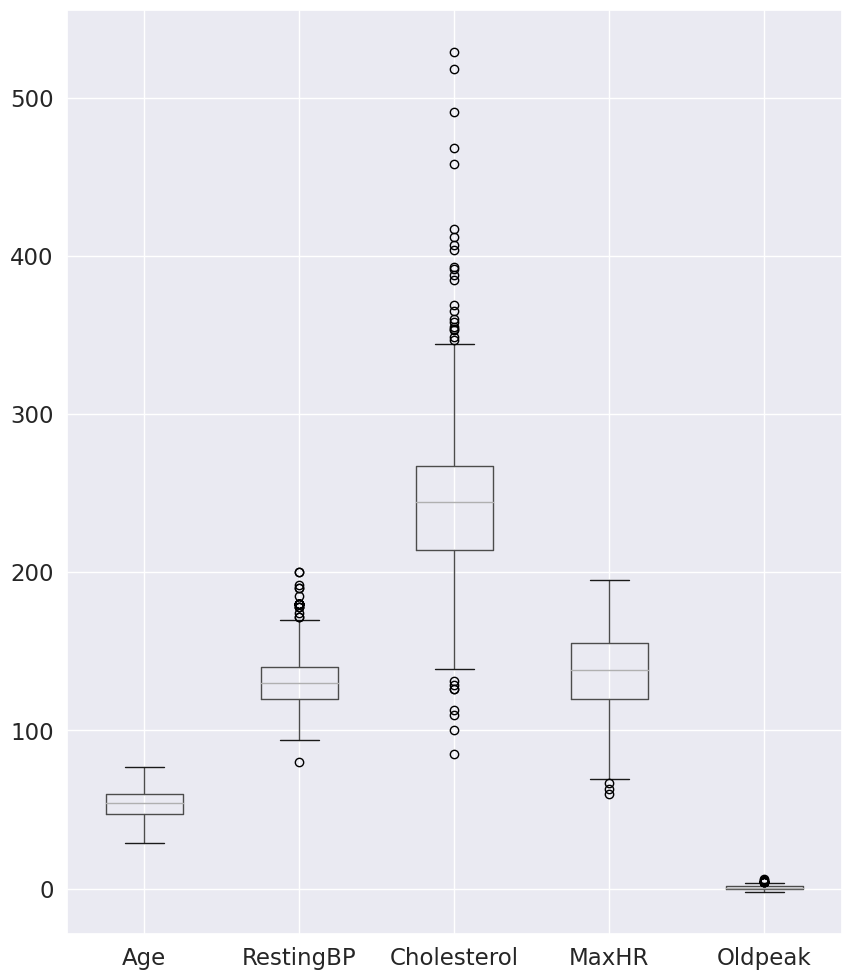

In [11]:
# show boxplot of numerical features
df_train.drop(['HeartDisease', 'FastingBS'], axis=1).boxplot(figsize=(10, 12))

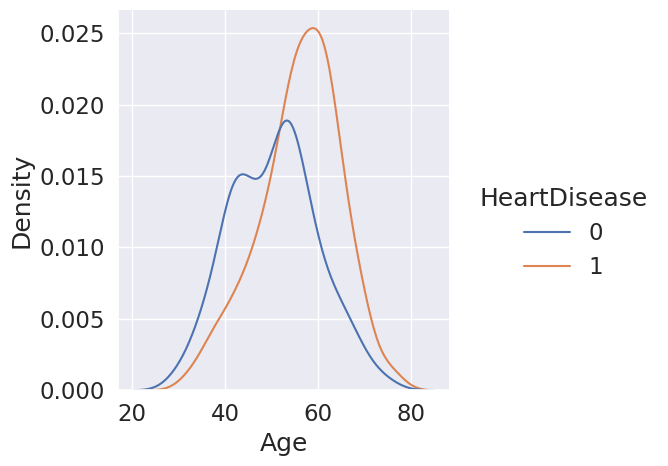

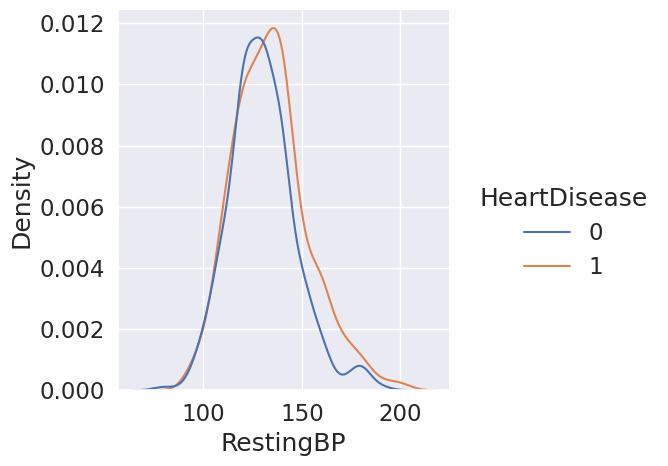

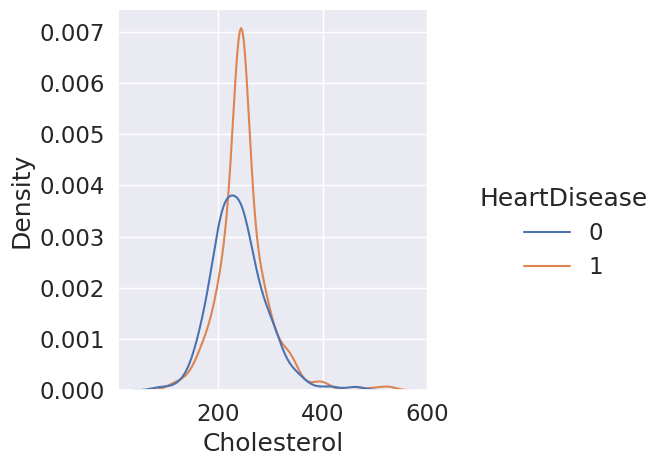

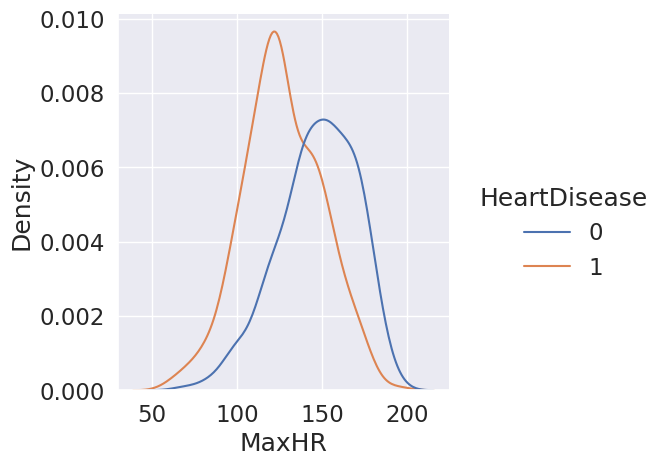

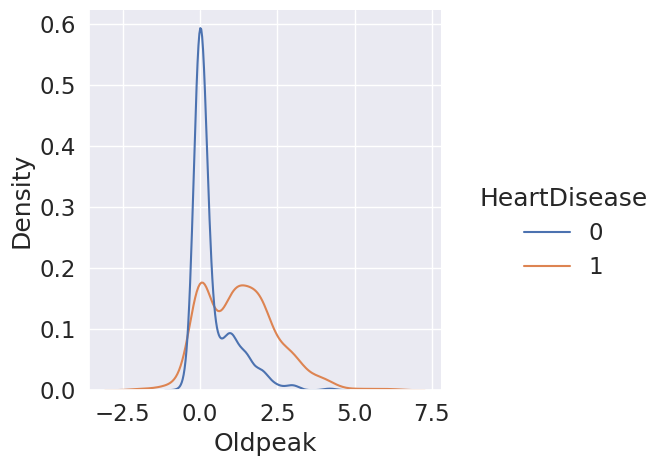

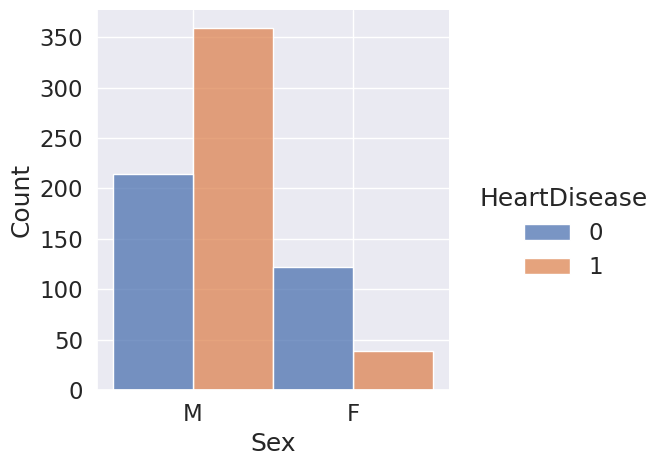

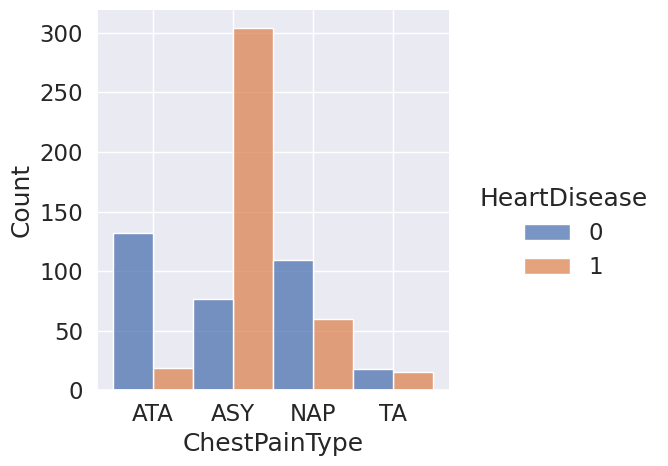

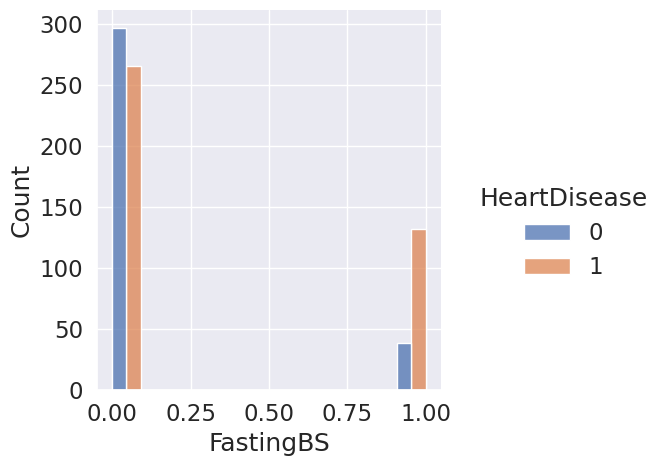

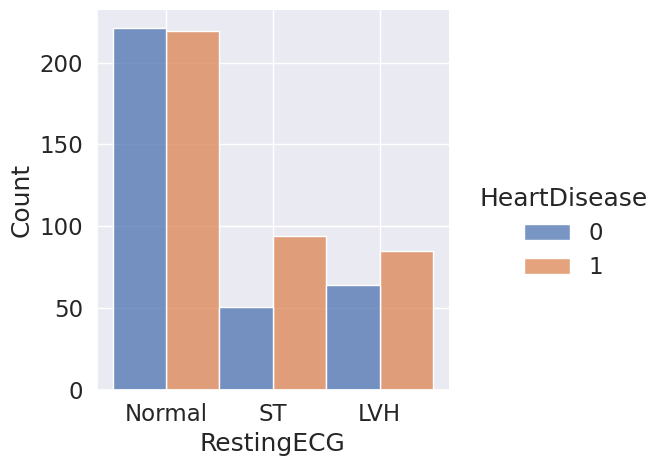

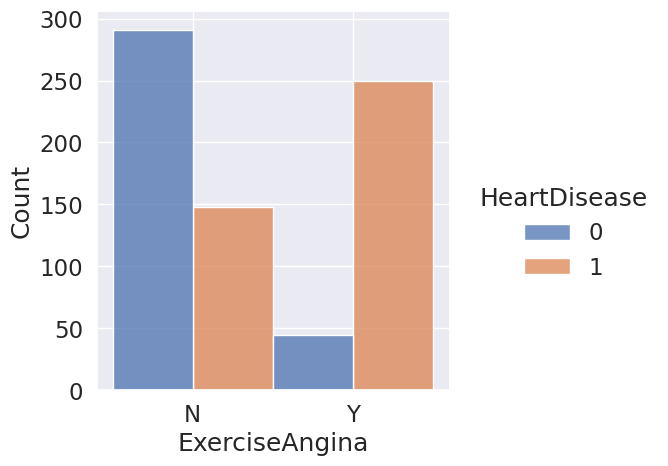

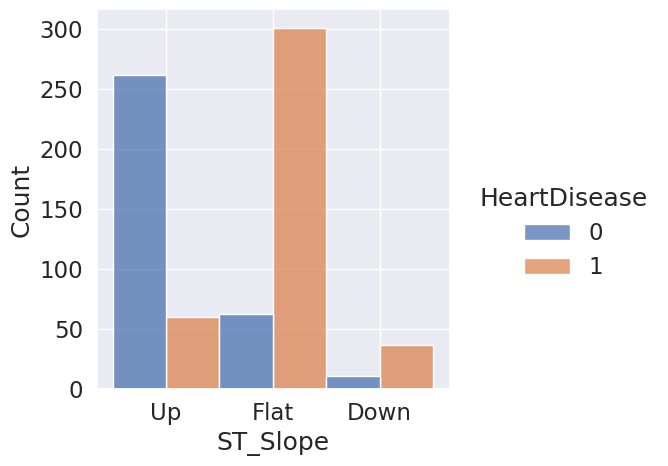

In [12]:
# show label dependent distribution
sns.displot(df_train, x='Age', hue="HeartDisease", kind="kde")
sns.displot(df_train, x='RestingBP', hue="HeartDisease", kind="kde")
sns.displot(df_train, x='Cholesterol', hue="HeartDisease", kind="kde")
sns.displot(df_train, x='MaxHR', hue="HeartDisease", kind="kde")
sns.displot(df_train, x='Oldpeak', hue="HeartDisease", kind="kde")
sns.displot(df_train, x='Sex', hue="HeartDisease", multiple="dodge")
sns.displot(df_train, x='ChestPainType', hue="HeartDisease", multiple="dodge")
sns.displot(df_train, x='FastingBS', hue="HeartDisease", multiple="dodge")
sns.displot(df_train, x='RestingECG', hue="HeartDisease", multiple="dodge")
sns.displot(df_train, x='ExerciseAngina', hue="HeartDisease", multiple="dodge")
sns.displot(df_train, x='ST_Slope', hue="HeartDisease", multiple="dodge")

Just from looking at the graphs MaxHR, Oldpeak, ChestPainType, ExerciseAngina, and ST_Slope seem to be the most important features to predict heart diseases. Both Sex and Age also look kinda useful for predicting but less so than the previously mentioned features.

### Visualizing correlation

In [13]:
# encode categorical columns using label encoding (maybe try different encoding schemes? one-hot?)
cat_columns = df_train.select_dtypes(['object']).columns
df_train[cat_columns] = df_train[cat_columns].apply(lambda x: x.astype('category').cat.codes)
df_test[cat_columns] = df_test[cat_columns].apply(lambda x: x.astype('category').cat.codes)

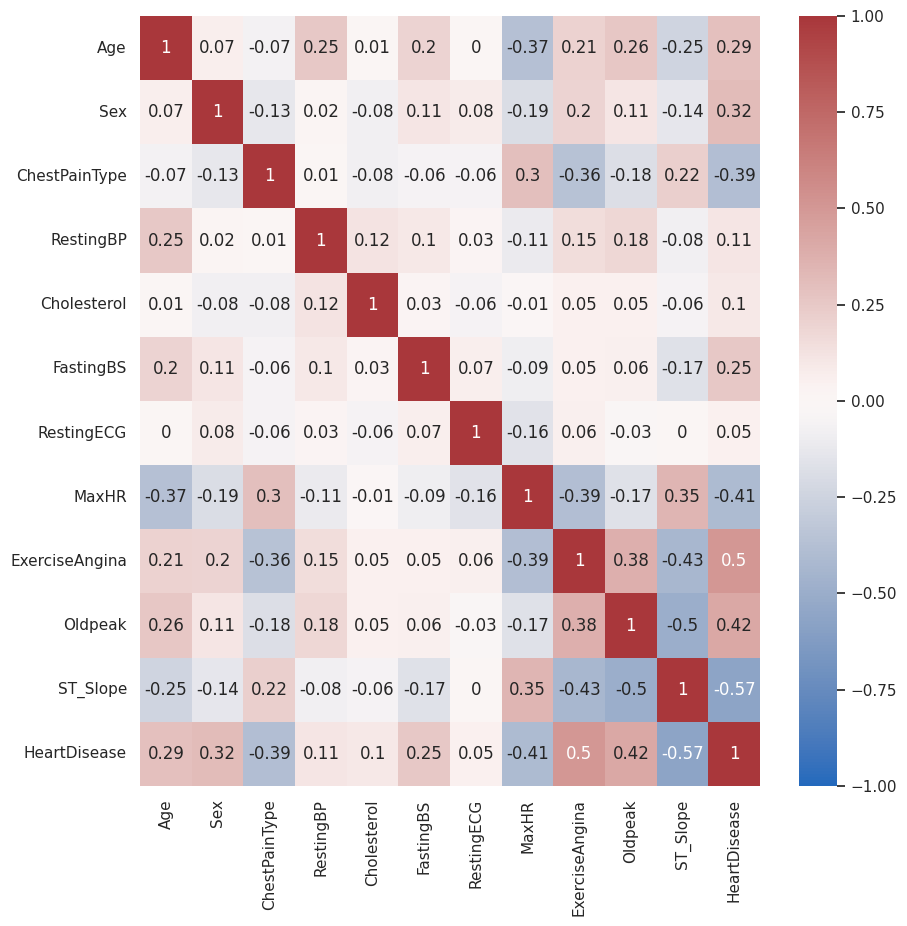

In [14]:
sns.set(font_scale=1)
matrix = df_train.corr().round(2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

Looking at the correlation values pretty much confirms what was seen in the distribution graphs

## Q2: Logistic Lasso Regression

In [15]:
# Construct pipeline & fit model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1, fit_intercept=True))
])
pipe.fit(df_train.drop('HeartDisease', axis=1), df_train['HeartDisease'])

# Print coefficients
lasso_coef = pd.Series(pipe.named_steps['lasso'].coef_)
lasso_coef.index = pd.Index(df_train.drop('HeartDisease', axis=1).columns)
print(lasso_coef.sort_values(ascending=False, key=abs))

# Important features
important_features = lasso_coef[lasso_coef != 0].index
print('Number of important features: ', important_features.shape[0])

# Calculate F1 score on test split
pred = pipe.predict(df_test.drop('HeartDisease', axis=1))
pred = pred > 0.5
f1 = f1_score(pred, df_test['HeartDisease'])
print('F1-score: ', f1)

ST_Slope         -0.136763
ExerciseAngina    0.069196
ChestPainType    -0.031884
Sex               0.018499
MaxHR            -0.013677
Oldpeak           0.004876
Age               0.000000
RestingBP         0.000000
Cholesterol       0.000000
FastingBS         0.000000
RestingECG        0.000000
dtype: float64
Number of important features:  6
F1-score:  0.8622222222222222


The non-zero coefficients of the fitted lasso regression again confirm that the previously mentioned values are important. It is very important to properly scale (normalize) the data for the coefficients to be representative of the feature importance.

### Standard logistic regression using only selected features

In [16]:
# Construct pipeline & fit model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(fit_intercept=True)),
])
pipe.fit(df_train[important_features], df_train['HeartDisease'])

# Calculate F1 score on test split
pred = pipe.predict(df_test[important_features])
pred = pred > 0.5
f1 = f1_score(pred, df_test['HeartDisease'])
print('F1-score: ', f1)

F1-score:  0.8372093023255814


## Q3: Decision Trees

In [17]:
pipe = Pipeline(steps=[    
    ('scaler', StandardScaler()),
    ('forest', DecisionTreeClassifier(random_state=42))
])
pipe.fit(df_train.drop('HeartDisease', axis=1), df_train['HeartDisease'])

# Print gini importances
gini = pd.Series(pipe.named_steps['forest'].feature_importances_)
gini.index = pd.Index(df_train.drop('HeartDisease', axis=1).columns)
print(gini.sort_values(ascending=False))

# Calculate F1 score on test split
pred = pipe.predict(df_test.drop('HeartDisease', axis=1))
pred = pred > 0.5
f1 = f1_score(pred, df_test['HeartDisease'])
print('F1-score: ', f1)

ST_Slope          0.405451
ChestPainType     0.115918
Oldpeak           0.097635
Cholesterol       0.092814
MaxHR             0.084627
RestingBP         0.066529
Sex               0.049404
Age               0.045243
FastingBS         0.020782
RestingECG        0.018029
ExerciseAngina    0.003569
dtype: float64
F1-score:  0.7870370370370371


## Q4: Multi-Layer Perceptrons

In [18]:
X = df_train.drop('HeartDisease', axis=1)
y = df_train['HeartDisease']
X_test = df_test.drop('HeartDisease', axis=1)
y_test = df_test['HeartDisease']

# create validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [19]:
input_shape = (X_train.shape[1])

model = keras.Sequential([
          keras.Input(shape=input_shape),
          layers.Dense(2*11, activation='relu'),
          layers.Dense(4*11, activation='relu'),
          layers.Dense(1, activation='sigmoid')
        ])
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 22)                264       
                                                                 
 dense_1 (Dense)             (None, 44)                1012      
                                                                 
 dense_2 (Dense)             (None, 1)                 45        
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 4s 54ms/step - loss: 0.6109 - accuracy: 0.6610 - val_loss: 0.5385 - val_accuracy: 0.7551
Epoch 2/10
19/19 [==============================] - 0s 7ms/step - loss: 0.5095 - accuracy: 0.8109 - val_loss: 0.4660 - val_accuracy: 0.8231
Epoch 3/10
19/19 [===================

In [20]:
# Test the model
test_loss, test_acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) > 0.5
print('Test accuracy:', test_acc)
print(classification_report(y_test, y_pred))

6/6 [==============================] - 0s 4ms/step
Test accuracy: 0.804347813129425
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        74
           1       0.84      0.83      0.83       110

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184



In [21]:
def f(X):
    return model.predict(X, batch_size=2048).flatten()

explainer = shap.Explainer(f,
                           shap.utils.sample(X_train, 100),
                           feature_names=X.columns.tolist(),
                           verbose=None,
                           seed=42)
shap_values = explainer(X_test)

1/1 [==============================] - 0s 67ms/step


Permutation explainer:   1%|          | 1/184 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:   2%|▏         | 3/184 [00:16<02:35,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:   2%|▏         | 4/184 [00:18<03:43,  1.24s/it]

1/1 [==============================] - 0s 32ms/step


Permutation explainer:   3%|▎         | 5/184 [00:20<04:53,  1.64s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:   3%|▎         | 6/184 [00:22<05:09,  1.74s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:   4%|▍         | 7/184 [00:24<05:09,  1.75s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:   4%|▍         | 8/184 [00:26<05:05,  1.73s/it]

1/1 [==============================] - 0s 26ms/step


Permutation explainer:   5%|▍         | 9/184 [00:27<05:05,  1.75s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:   5%|▌         | 10/184 [00:29<05:04,  1.75s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:   6%|▌         | 11/184 [00:31<05:02,  1.75s/it]

1/1 [==============================] - 0s 36ms/step


Permutation explainer:   7%|▋         | 12/184 [00:33<05:32,  1.93s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:   7%|▋         | 13/184 [00:35<05:26,  1.91s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:   8%|▊         | 14/184 [00:37<05:12,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:   8%|▊         | 15/184 [00:38<05:05,  1.80s/it]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:   9%|▊         | 16/184 [00:40<05:00,  1.79s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:   9%|▉         | 17/184 [00:42<04:55,  1.77s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  10%|▉         | 18/184 [00:44<04:51,  1.76s/it]

1/1 [==============================] - 0s 32ms/step


Permutation explainer:  10%|█         | 19/184 [00:46<05:21,  1.95s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  11%|█         | 20/184 [00:48<05:13,  1.91s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  11%|█▏        | 21/184 [00:49<04:59,  1.84s/it]

1/1 [==============================] - 0s 28ms/step


Permutation explainer:  12%|█▏        | 22/184 [00:51<04:52,  1.80s/it]

1/1 [==============================] - 0s 28ms/step


Permutation explainer:  12%|█▎        | 23/184 [00:53<04:46,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  13%|█▎        | 24/184 [00:55<04:45,  1.78s/it]

1/1 [==============================] - 0s 34ms/step


Permutation explainer:  14%|█▎        | 25/184 [00:56<04:39,  1.76s/it]

1/1 [==============================] - 0s 32ms/step


Permutation explainer:  14%|█▍        | 26/184 [00:59<05:10,  1.96s/it]

1/1 [==============================] - 0s 27ms/step


Permutation explainer:  15%|█▍        | 27/184 [01:01<05:01,  1.92s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  15%|█▌        | 28/184 [01:02<04:47,  1.84s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  16%|█▌        | 29/184 [01:04<04:42,  1.83s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  16%|█▋        | 30/184 [01:06<04:38,  1.81s/it]

1/1 [==============================] - 0s 32ms/step


Permutation explainer:  17%|█▋        | 31/184 [01:08<05:07,  2.01s/it]

1/1 [==============================] - 0s 42ms/step


Permutation explainer:  17%|█▋        | 32/184 [01:11<05:27,  2.15s/it]

1/1 [==============================] - 0s 41ms/step


Permutation explainer:  18%|█▊        | 33/184 [01:13<05:28,  2.18s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  18%|█▊        | 34/184 [01:15<05:11,  2.08s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  19%|█▉        | 35/184 [01:17<04:55,  1.98s/it]

1/1 [==============================] - 0s 30ms/step


Permutation explainer:  20%|█▉        | 36/184 [01:19<04:45,  1.93s/it]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:  20%|██        | 37/184 [01:21<05:25,  2.22s/it]

1/1 [==============================] - 0s 45ms/step


Permutation explainer:  21%|██        | 38/184 [01:25<06:06,  2.51s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  21%|██        | 39/184 [01:26<05:31,  2.29s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  22%|██▏       | 40/184 [01:28<05:05,  2.12s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  22%|██▏       | 41/184 [01:30<04:48,  2.02s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  23%|██▎       | 42/184 [01:32<04:35,  1.94s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  23%|██▎       | 43/184 [01:33<04:22,  1.86s/it]

1/1 [==============================] - 0s 54ms/step


Permutation explainer:  24%|██▍       | 44/184 [01:35<04:19,  1.85s/it]

1/1 [==============================] - 0s 35ms/step


Permutation explainer:  24%|██▍       | 45/184 [01:38<04:42,  2.03s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  25%|██▌       | 46/184 [01:39<04:26,  1.93s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  26%|██▌       | 47/184 [01:41<04:19,  1.90s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  26%|██▌       | 48/184 [01:43<04:14,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  27%|██▋       | 49/184 [01:45<04:07,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  27%|██▋       | 50/184 [01:46<04:01,  1.80s/it]

1/1 [==============================] - 0s 37ms/step


Permutation explainer:  28%|██▊       | 51/184 [01:48<04:03,  1.83s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  28%|██▊       | 52/184 [01:51<04:20,  1.97s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  29%|██▉       | 53/184 [01:52<04:08,  1.90s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  29%|██▉       | 54/184 [01:54<04:00,  1.85s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  30%|██▉       | 55/184 [01:56<03:51,  1.80s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  30%|███       | 56/184 [01:57<03:45,  1.76s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  31%|███       | 57/184 [01:59<03:41,  1.74s/it]

1/1 [==============================] - 0s 33ms/step


Permutation explainer:  32%|███▏      | 58/184 [02:01<03:43,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  32%|███▏      | 59/184 [02:03<04:05,  1.96s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  33%|███▎      | 60/184 [02:05<03:53,  1.88s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  33%|███▎      | 61/184 [02:07<03:43,  1.82s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  34%|███▎      | 62/184 [02:08<03:37,  1.78s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  34%|███▍      | 63/184 [02:10<03:34,  1.77s/it]

1/1 [==============================] - 0s 26ms/step


Permutation explainer:  35%|███▍      | 64/184 [02:12<03:32,  1.77s/it]

1/1 [==============================] - 0s 34ms/step


Permutation explainer:  35%|███▌      | 65/184 [02:14<03:35,  1.81s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  36%|███▌      | 66/184 [02:16<03:54,  1.99s/it]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:  36%|███▋      | 67/184 [02:18<03:40,  1.89s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  37%|███▋      | 68/184 [02:20<03:33,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  38%|███▊      | 69/184 [02:21<03:28,  1.81s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  38%|███▊      | 70/184 [02:23<03:23,  1.78s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  39%|███▊      | 71/184 [02:25<03:20,  1.77s/it]

1/1 [==============================] - 0s 34ms/step


Permutation explainer:  39%|███▉      | 72/184 [02:27<03:21,  1.80s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  40%|███▉      | 73/184 [02:29<03:40,  1.98s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  40%|████      | 74/184 [02:31<03:30,  1.91s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  41%|████      | 75/184 [02:33<03:22,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:  41%|████▏     | 76/184 [02:34<03:14,  1.80s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  42%|████▏     | 77/184 [02:36<03:09,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  42%|████▏     | 78/184 [02:38<03:06,  1.76s/it]

1/1 [==============================] - 0s 36ms/step


Permutation explainer:  43%|████▎     | 79/184 [02:40<03:11,  1.82s/it]

1/1 [==============================] - 0s 27ms/step


Permutation explainer:  43%|████▎     | 80/184 [02:42<03:26,  1.99s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  44%|████▍     | 81/184 [02:44<03:18,  1.92s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  45%|████▍     | 82/184 [02:46<03:11,  1.88s/it]

1/1 [==============================] - 0s 26ms/step


Permutation explainer:  45%|████▌     | 83/184 [02:47<03:06,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  46%|████▌     | 84/184 [02:49<02:59,  1.80s/it]

1/1 [==============================] - 0s 26ms/step


Permutation explainer:  46%|████▌     | 85/184 [02:51<02:55,  1.78s/it]

1/1 [==============================] - 0s 41ms/step


Permutation explainer:  47%|████▋     | 86/184 [02:53<03:00,  1.85s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  47%|████▋     | 87/184 [02:55<03:10,  1.97s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  48%|████▊     | 88/184 [02:57<03:01,  1.89s/it]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:  48%|████▊     | 89/184 [02:58<02:54,  1.84s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  49%|████▉     | 90/184 [03:00<02:49,  1.81s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  49%|████▉     | 91/184 [03:02<02:46,  1.79s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  50%|█████     | 92/184 [03:04<02:43,  1.78s/it]

1/1 [==============================] - 0s 36ms/step


Permutation explainer:  51%|█████     | 93/184 [03:06<02:49,  1.86s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  51%|█████     | 94/184 [03:08<02:59,  1.99s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  52%|█████▏    | 95/184 [03:10<02:50,  1.92s/it]

1/1 [==============================] - 0s 33ms/step


Permutation explainer:  52%|█████▏    | 96/184 [03:12<03:07,  2.14s/it]

1/1 [==============================] - 0s 33ms/step


Permutation explainer:  53%|█████▎    | 97/184 [03:14<03:03,  2.11s/it]

1/1 [==============================] - 0s 35ms/step


Permutation explainer:  53%|█████▎    | 98/184 [03:17<03:00,  2.10s/it]

1/1 [==============================] - 0s 51ms/step


Permutation explainer:  54%|█████▍    | 99/184 [03:19<03:05,  2.18s/it]

1/1 [==============================] - 0s 33ms/step


Permutation explainer:  54%|█████▍    | 100/184 [03:21<03:11,  2.28s/it]

1/1 [==============================] - 0s 36ms/step


Permutation explainer:  55%|█████▍    | 101/184 [03:24<03:05,  2.23s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  55%|█████▌    | 102/184 [03:25<02:56,  2.16s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  56%|█████▌    | 103/184 [03:27<02:46,  2.05s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  57%|█████▋    | 104/184 [03:29<02:37,  1.97s/it]

1/1 [==============================] - 0s 34ms/step


Permutation explainer:  57%|█████▋    | 105/184 [03:31<02:35,  1.97s/it]

1/1 [==============================] - 0s 26ms/step


Permutation explainer:  58%|█████▊    | 106/184 [03:33<02:44,  2.11s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  58%|█████▊    | 107/184 [03:35<02:35,  2.02s/it]

1/1 [==============================] - 0s 27ms/step


Permutation explainer:  59%|█████▊    | 108/184 [03:37<02:27,  1.94s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  59%|█████▉    | 109/184 [03:39<02:21,  1.89s/it]

1/1 [==============================] - 0s 29ms/step


Permutation explainer:  60%|█████▉    | 110/184 [03:41<02:18,  1.87s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  60%|██████    | 111/184 [03:42<02:15,  1.86s/it]

1/1 [==============================] - 0s 43ms/step


Permutation explainer:  61%|██████    | 112/184 [03:45<02:21,  1.96s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  61%|██████▏   | 113/184 [03:47<02:26,  2.07s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  62%|██████▏   | 114/184 [03:49<02:19,  1.99s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  62%|██████▎   | 115/184 [03:51<02:12,  1.93s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  63%|██████▎   | 116/184 [03:52<02:09,  1.91s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  64%|██████▎   | 117/184 [03:54<02:05,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  64%|██████▍   | 118/184 [03:56<02:02,  1.85s/it]

1/1 [==============================] - 0s 35ms/step


Permutation explainer:  65%|██████▍   | 119/184 [03:58<02:12,  2.03s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  65%|██████▌   | 120/184 [04:00<02:09,  2.02s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  66%|██████▌   | 121/184 [04:02<02:03,  1.95s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  66%|██████▋   | 122/184 [04:04<01:57,  1.89s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  67%|██████▋   | 123/184 [04:06<01:54,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  67%|██████▋   | 124/184 [04:08<01:51,  1.86s/it]

1/1 [==============================] - 0s 44ms/step


Permutation explainer:  68%|██████▊   | 125/184 [04:10<01:50,  1.88s/it]

1/1 [==============================] - 0s 27ms/step


Permutation explainer:  68%|██████▊   | 126/184 [04:12<02:00,  2.08s/it]

1/1 [==============================] - 0s 28ms/step


Permutation explainer:  69%|██████▉   | 127/184 [04:14<01:53,  1.99s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  70%|██████▉   | 128/184 [04:16<01:47,  1.93s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  70%|███████   | 129/184 [04:18<01:44,  1.89s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  71%|███████   | 130/184 [04:19<01:40,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  71%|███████   | 131/184 [04:21<01:38,  1.86s/it]

1/1 [==============================] - 0s 33ms/step


Permutation explainer:  72%|███████▏  | 132/184 [04:23<01:41,  1.95s/it]

1/1 [==============================] - 0s 27ms/step


Permutation explainer:  72%|███████▏  | 133/184 [04:26<01:45,  2.07s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  73%|███████▎  | 134/184 [04:27<01:39,  1.99s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  73%|███████▎  | 135/184 [04:29<01:35,  1.95s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  74%|███████▍  | 136/184 [04:31<01:31,  1.90s/it]

1/1 [==============================] - 0s 28ms/step


Permutation explainer:  74%|███████▍  | 137/184 [04:33<01:28,  1.89s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  75%|███████▌  | 138/184 [04:35<01:26,  1.87s/it]

1/1 [==============================] - 0s 36ms/step


Permutation explainer:  76%|███████▌  | 139/184 [04:37<01:32,  2.05s/it]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:  76%|███████▌  | 140/184 [04:39<01:29,  2.04s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  77%|███████▋  | 141/184 [04:41<01:25,  1.98s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  77%|███████▋  | 142/184 [04:43<01:20,  1.92s/it]

1/1 [==============================] - 0s 30ms/step


Permutation explainer:  78%|███████▊  | 143/184 [04:45<01:17,  1.89s/it]

1/1 [==============================] - 0s 29ms/step


Permutation explainer:  78%|███████▊  | 144/184 [04:47<01:14,  1.86s/it]

1/1 [==============================] - 0s 36ms/step


Permutation explainer:  79%|███████▉  | 145/184 [04:49<01:13,  1.89s/it]

1/1 [==============================] - 0s 30ms/step


Permutation explainer:  79%|███████▉  | 146/184 [04:51<01:19,  2.09s/it]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:  80%|███████▉  | 147/184 [04:53<01:13,  1.99s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  80%|████████  | 148/184 [04:55<01:09,  1.92s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  81%|████████  | 149/184 [04:56<01:05,  1.88s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  82%|████████▏ | 150/184 [04:58<01:03,  1.86s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  82%|████████▏ | 151/184 [05:00<01:01,  1.85s/it]

1/1 [==============================] - 0s 42ms/step


Permutation explainer:  83%|████████▎ | 152/184 [05:02<01:02,  1.96s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  83%|████████▎ | 153/184 [05:05<01:04,  2.08s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  84%|████████▎ | 154/184 [05:06<00:59,  1.98s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  84%|████████▍ | 155/184 [05:08<00:55,  1.92s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  85%|████████▍ | 156/184 [05:10<00:53,  1.90s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  85%|████████▌ | 157/184 [05:12<00:50,  1.87s/it]

1/1 [==============================] - 0s 25ms/step


Permutation explainer:  86%|████████▌ | 158/184 [05:14<00:48,  1.86s/it]

1/1 [==============================] - 0s 32ms/step


Permutation explainer:  86%|████████▋ | 159/184 [05:16<00:50,  2.01s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  87%|████████▋ | 160/184 [05:18<00:48,  2.04s/it]

1/1 [==============================] - 0s 33ms/step


Permutation explainer:  88%|████████▊ | 161/184 [05:21<00:51,  2.24s/it]

1/1 [==============================] - 0s 32ms/step


Permutation explainer:  88%|████████▊ | 162/184 [05:23<00:48,  2.21s/it]

1/1 [==============================] - 0s 34ms/step


Permutation explainer:  89%|████████▊ | 163/184 [05:25<00:46,  2.21s/it]

1/1 [==============================] - 0s 49ms/step


Permutation explainer:  89%|████████▉ | 164/184 [05:27<00:44,  2.22s/it]

1/1 [==============================] - 0s 41ms/step


Permutation explainer:  90%|████████▉ | 165/184 [05:30<00:46,  2.43s/it]

1/1 [==============================] - 0s 34ms/step


Permutation explainer:  90%|█████████ | 166/184 [05:32<00:42,  2.35s/it]

1/1 [==============================] - 0s 32ms/step


Permutation explainer:  91%|█████████ | 167/184 [05:35<00:39,  2.30s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  91%|█████████▏| 168/184 [05:37<00:35,  2.21s/it]

1/1 [==============================] - 0s 31ms/step


Permutation explainer:  92%|█████████▏| 169/184 [05:38<00:31,  2.09s/it]

1/1 [==============================] - 0s 38ms/step


Permutation explainer:  92%|█████████▏| 170/184 [05:40<00:28,  2.04s/it]

1/1 [==============================] - 0s 33ms/step


Permutation explainer:  93%|█████████▎| 171/184 [05:43<00:28,  2.18s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  93%|█████████▎| 172/184 [05:45<00:24,  2.08s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  94%|█████████▍| 173/184 [05:47<00:22,  2.00s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  95%|█████████▍| 174/184 [05:48<00:19,  1.96s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  95%|█████████▌| 175/184 [05:50<00:17,  1.92s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  96%|█████████▌| 176/184 [05:52<00:15,  1.88s/it]

1/1 [==============================] - 0s 32ms/step


Permutation explainer:  96%|█████████▌| 177/184 [05:54<00:13,  1.93s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  97%|█████████▋| 178/184 [05:56<00:12,  2.07s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  97%|█████████▋| 179/184 [05:58<00:09,  1.99s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  98%|█████████▊| 180/184 [06:00<00:07,  1.91s/it]

1/1 [==============================] - 0s 23ms/step


Permutation explainer:  98%|█████████▊| 181/184 [06:02<00:05,  1.87s/it]

1/1 [==============================] - 0s 24ms/step


Permutation explainer:  99%|█████████▉| 182/184 [06:04<00:03,  1.85s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer:  99%|█████████▉| 183/184 [06:05<00:01,  1.83s/it]

1/1 [==============================] - 0s 39ms/step


Permutation explainer: 100%|██████████| 184/184 [06:08<00:00,  1.94s/it]

1/1 [==============================] - 0s 22ms/step


Permutation explainer: 185it [06:10,  2.01s/it]


Explanation why test sample 0 is in class 1


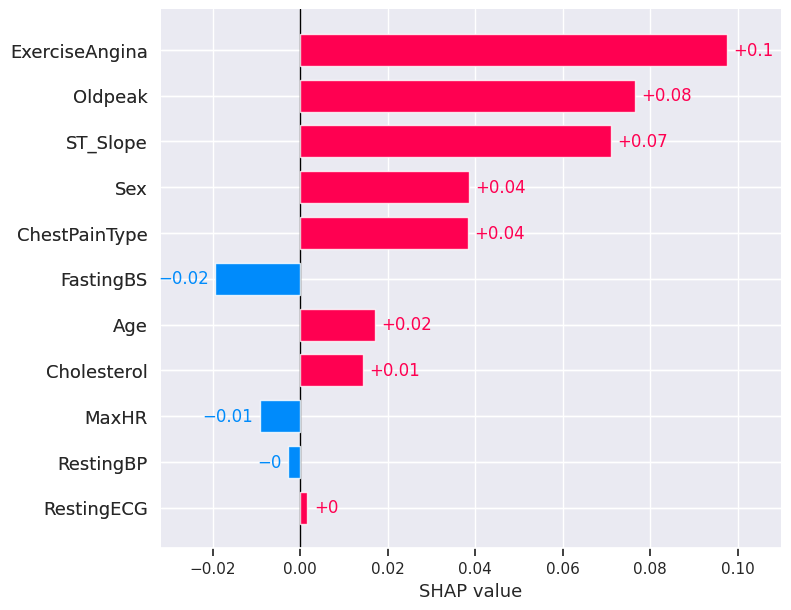

Explanation why test sample 1 is in class 1


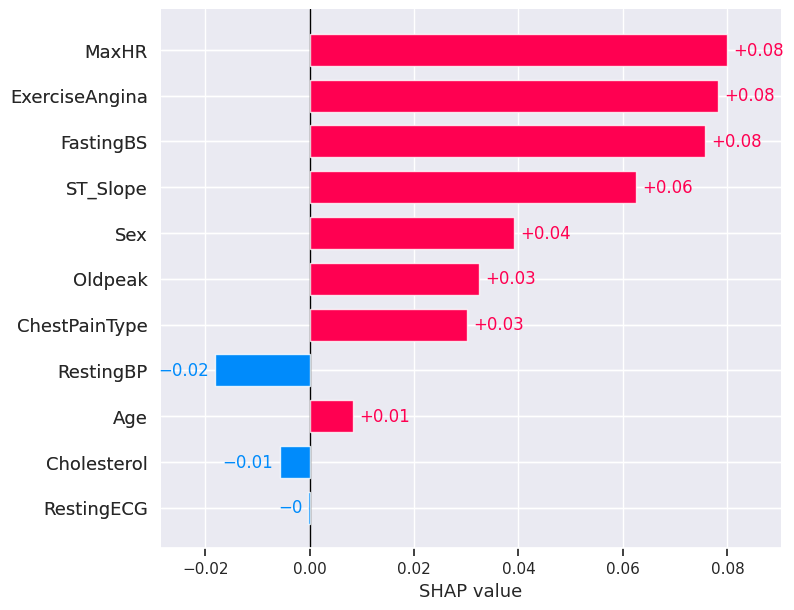

Explanation why test sample 2 is in class 1


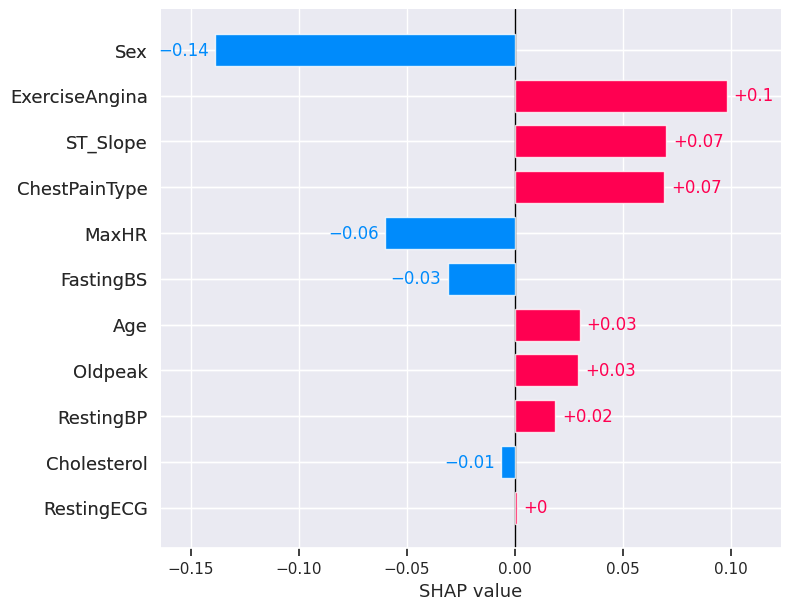

Explanation why test sample 3 is in class 1


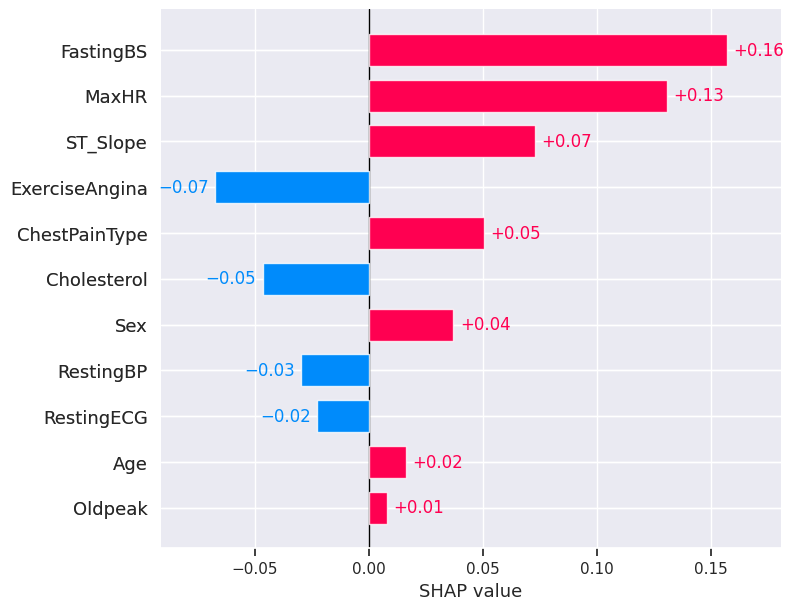

Explanation why test sample 179 is in class 0


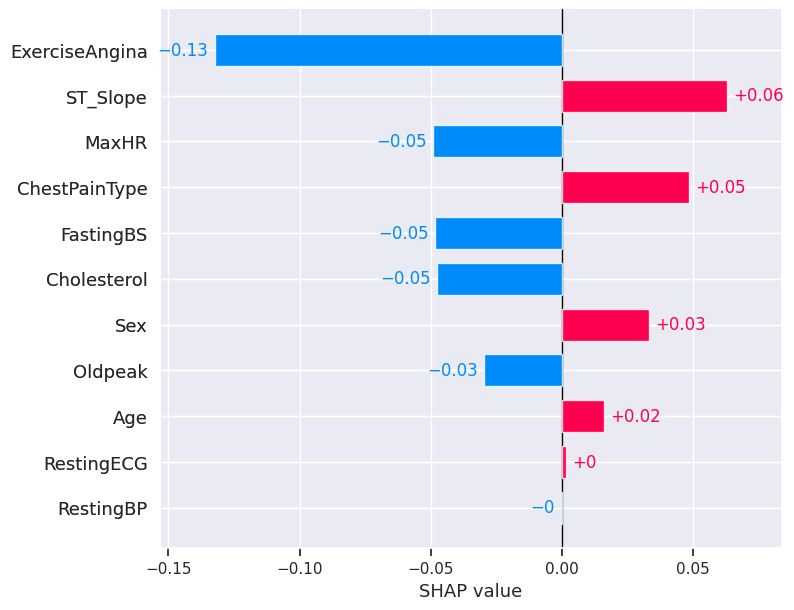

Explanation why test sample 180 is in class 0


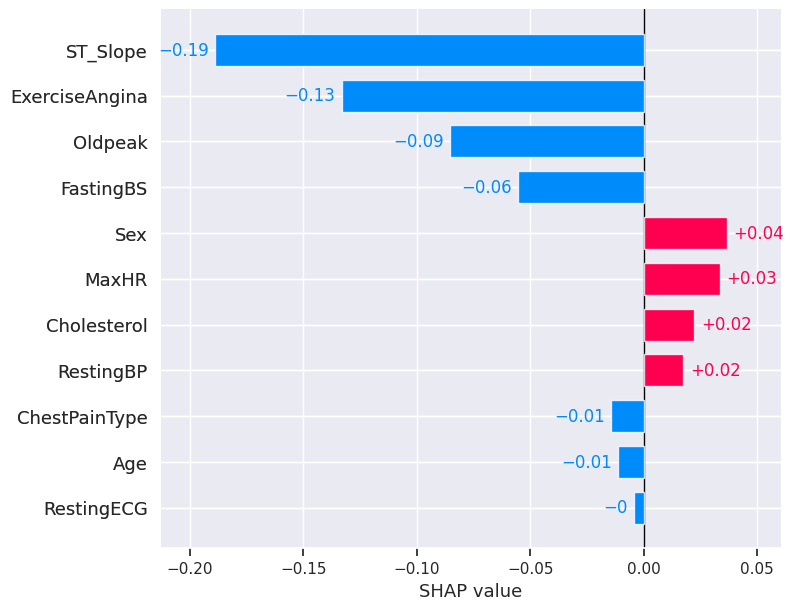

Explanation why test sample 181 is in class 0


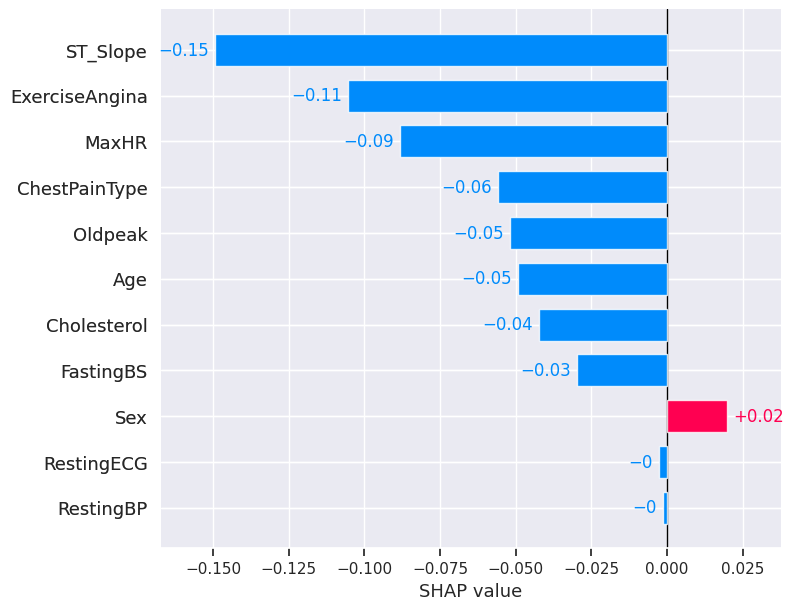

Explanation why test sample 183 is in class 0


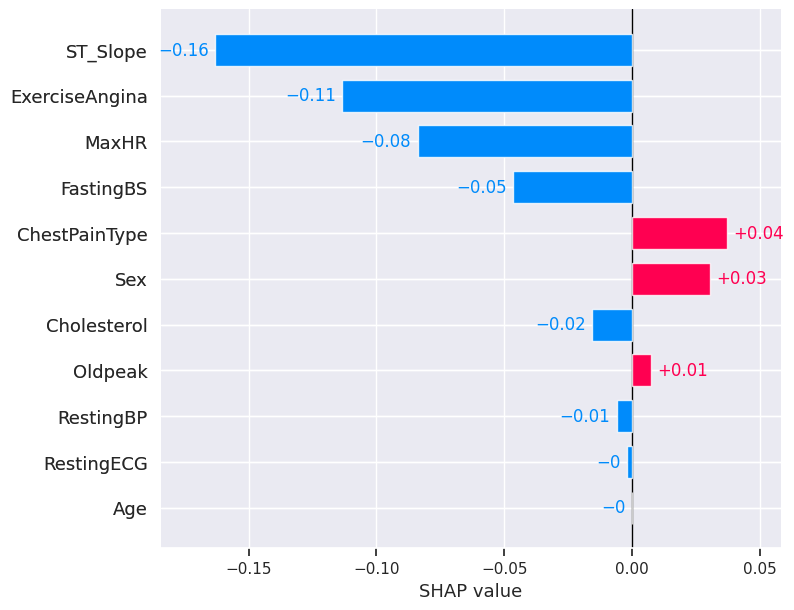

In [22]:
for idx in (0, 1, 2, 3, 179, 180, 181, 183):
  print("Explanation why test sample %i is in class %i" %(idx, y_test[idx]))
  shap.plots.bar(shap_values[idx], max_display=11)

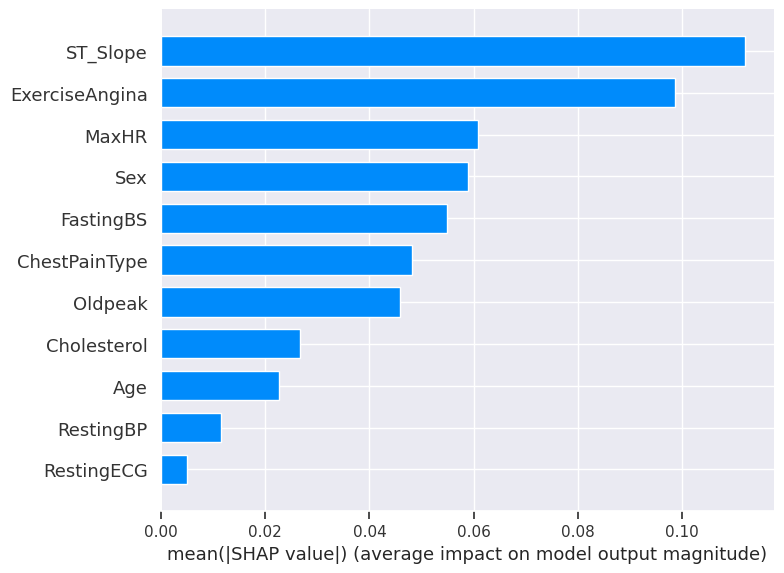

In [23]:
shap.summary_plot(shap_values, plot_type="bar")

## Challenge 1: Neural Additive Models

In [30]:
input_shape = (X_train.shape[1])
input = keras.Input(shape=input_shape)
print(input[0, 0].shape)

subnets = []
for i in range(11):
    net = keras.Sequential([
        keras.Input(shape=1),
        layers.Dense(4, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])(input[:, i:i+1])
    subnets.append(net)

output = layers.average(subnets)
model = keras.Model(inputs=input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

()
Epoch 1/10
19/19 [==============================] - 7s 33ms/step - loss: 0.6985 - accuracy: 0.4702 - val_loss: 0.6878 - val_accuracy: 0.5714
Epoch 2/10
19/19 [==============================] - 0s 9ms/step - loss: 0.6861 - accuracy: 0.5571 - val_loss: 0.6762 - val_accuracy: 0.6871
Epoch 3/10
19/19 [==============================] - 0s 8ms/step - loss: 0.6740 - accuracy: 0.6763 - val_loss: 0.6654 - val_accuracy: 0.7347
Epoch 4/10
19/19 [==============================] - 0s 8ms/step - loss: 0.6628 - accuracy: 0.7376 - val_loss: 0.6548 - val_accuracy: 0.7823
Epoch 5/10
19/19 [==============================] - 0s 9ms/step - loss: 0.6519 - accuracy: 0.7547 - val_loss: 0.6445 - val_accuracy: 0.8095
Epoch 6/10
19/19 [==============================] - 0s 8ms/step - loss: 0.6414 - accuracy: 0.7751 - val_loss: 0.6345 - val_accuracy: 0.8095
Epoch 7/10
19/19 [==============================] - 0s 7ms/step - loss: 0.6313 - accuracy: 0.7853 - val_loss: 0.6247 - val_accuracy: 0.8367
Epoch 8/10
19/19

In [31]:
# Test the model
test_loss, test_acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) > 0.5
print('Test accuracy:', test_acc)
print(classification_report(y_test, y_pred))

6/6 [==============================] - 1s 5ms/step
Test accuracy: 0.8260869383811951
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        74
           1       0.84      0.88      0.86       110

    accuracy                           0.83       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.83      0.83      0.82       184



In [32]:
# get raw outputs of subnets
concat = layers.Concatenate(axis=1)(subnets)
interpretable_model = keras.Model(inputs=input, outputs=concat)
importances = interpretable_model.predict(X_test)
importances = np.abs(importances - 0.5)
importances_df = pd.DataFrame(importances)
importances_df.columns = X.columns.tolist()

6/6 [==============================] - 1s 4ms/step


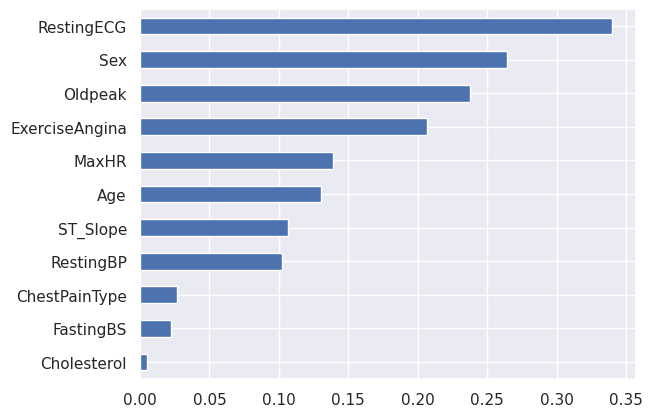

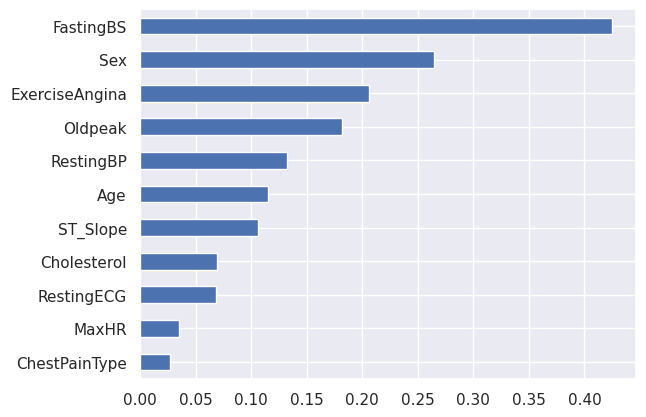

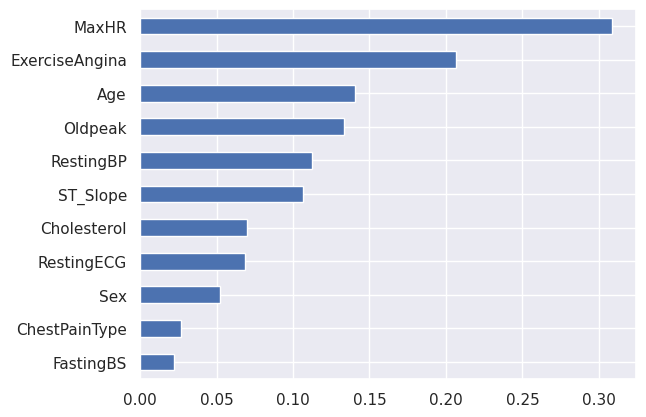

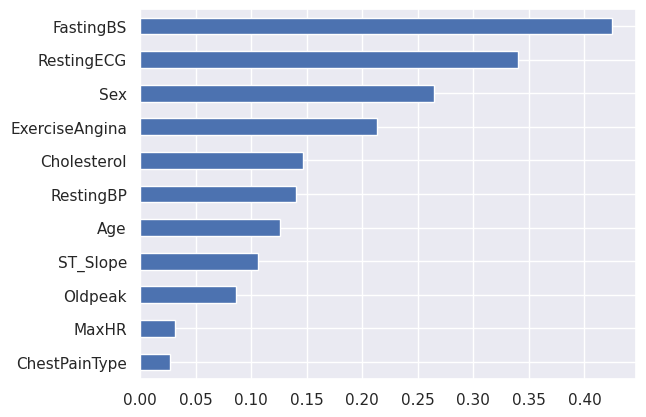

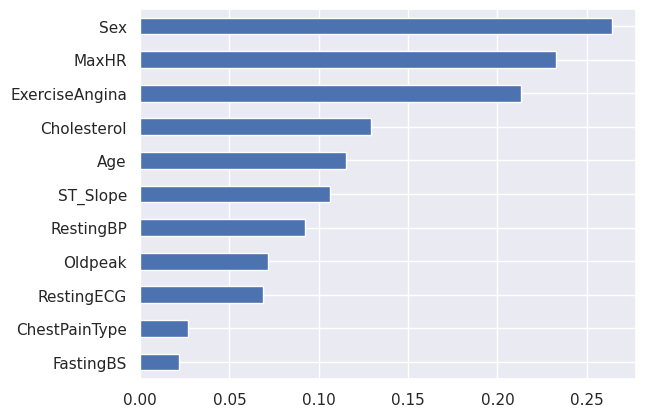

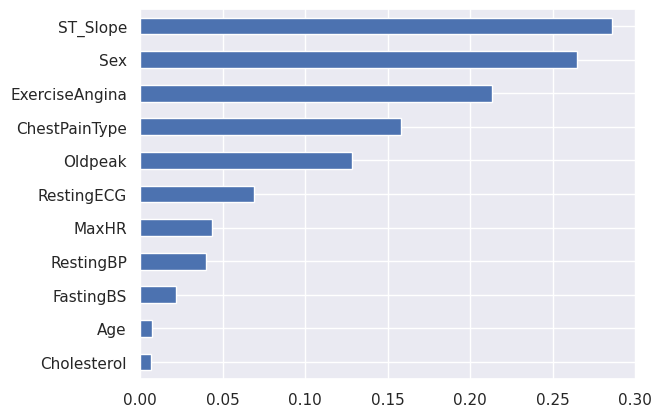

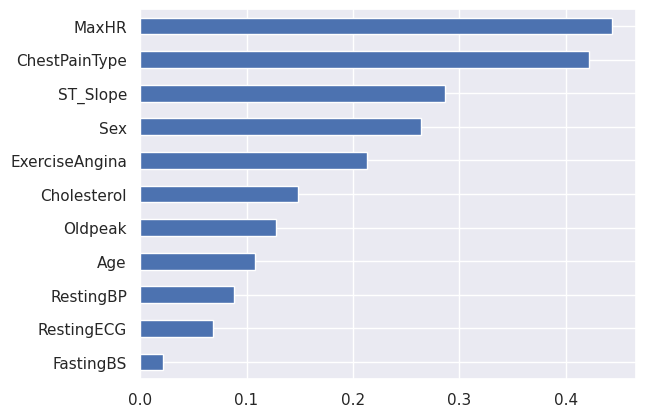

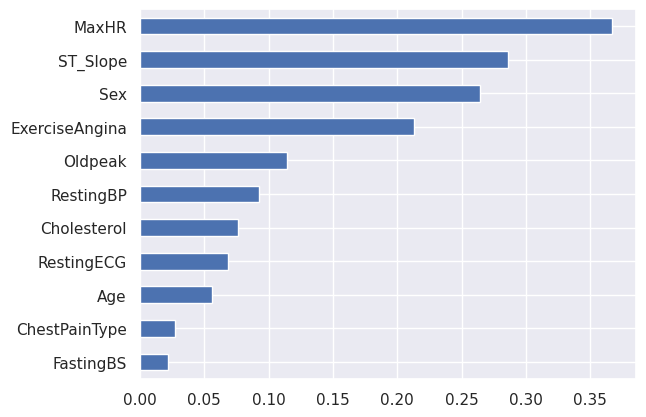

In [33]:
# plot 4 pos & 4 neg test samples
for idx in (0, 1, 2, 3, 179, 180, 181, 183):
  sample = importances_df.iloc[idx].sort_values(ascending=True)
  sample.plot.barh()
  plt.show()